<img src="images/logo/eooffshore_banner.png" width="48%" />&nbsp;

<img src="images/logo/seai.png" width="25%" /> <span /> <img src="images/logo/ucd.png" width="7%" />

# CCMP Wind Data for Irish Continental Shelf region

## Introduction

[Cross-Calibrated Multi-Platform (CCMP)](https://www.remss.com/measurements/ccmp/) is a Level-3 gridded ocean surface vector wind analysis data set produced using satellite, moored buoy, and model wind data. The original CCMP product (V1.1) was produced with funding from the NASA REASoN and MEaSUREs programs, while the V2.x versions are generated by [Remote Sensing Systems (RSS)](https://www.remss.com/). Further details and example usage may be found in the following publications:

* [Atlas et al. (2011) - A Cross-calibrated, Multiplatform Ocean Surface Wind Velocity Product for Meteorological and Oceanographic Applications](https://doi.org/10.1175/2010BAMS2946.1)
* [Wentz et al. (2015) - Cross-Calibrated Multi-Platform (CCMP) 6-hourly ocean vector wind analysis product on 0.25 deg grid, Version 2.0 (accessed 2022/05/15)](https://www.remss.com/measurements/ccmp/)
* [Scott et al. (2016) - Improvements and Advances to the Cross-Calibrated Multi-Platform (CCMP) Ocean Vector Wind Analysis (V2.0 release) Applications](https://www.researchgate.net/publication/298552723_Improvements_and_Advances_to_the_Cross-Calibrated_Multi-Platform_CCMP_Ocean_Vector_Wind_Analysis_V20_release)
* [Mears et al. (2019) - A Near-Real-Time Version of the Cross-Calibrated Multiplatform (CCMP) Ocean Surface Wind Velocity Data Set](https://doi.org/10.1029/2019JC015367)
* [Hummels et al. (2020) - Surface cooling caused by rare but intense near-inertial wave induced mixing in the tropical Atlantic](https://doi.org/10.1038/s41467-020-17601-x)
* [Xu et al. (2020) - Proliferation of offshore wind farms in the North Sea and surrounding waters revealed by satellite image time series](https://doi.org/10.1016/j.rser.2020.110167)
* [Gentemann (2021) - Accessing Sea Surface Temperature Data on the Cloud (Pangeo Showcase)](https://doi.org/10.5281/zenodo.4783039)

This notebook provides details of:
1. CCMP wind data products retrieval.
1. The creation of the CCMP Zarr wind store that is included in the EOOffshore catalog.
1. A brief look at this Zarr store, including a demonstration of wind speed calculation.

This CCMP Zarr store has been uploaded to [Zenodo](https://zenodo.org/record/6958151).

**How to cite:** 
1. O'Callaghan, D. and McBreen, S.: Scalable Offshore Wind Analysis With Pangeo, EGU General Assembly 2022, Vienna, Austria, 23–27 May 2022, EGU22-2746, [https://doi.org/10.5194/egusphere-egu22-2746](https://doi.org/10.5194/egusphere-egu22-2746), 2022.
1. [O'Callaghan, D. and McBreen, S.: EOOffshore: CCMP v0.2.1.NRT Wind Data for the Irish Continental Shelf Region,  (1.0.0) [Data set], Zenodo, 2022.](https://zenodo.org/record/6958151) [![https://doi.org/10.5281/zenodo.6958151](https://zenodo.org/badge/DOI/10.5281/zenodo.6958151.svg)](https://doi.org/10.5281/zenodo.6958151)

**Note: more extensive usage of the EOOffshore CCMP Zarr store may be found in the following notebooks:**
* [Offshore Wind in Irish Areas Of Interest](./Offshore_Wind_AOI.ipynb)
* [Comparison of Offshore Wind Speed Extrapolation and Power Density Estimation](./Comparison_Wind_Power.ipynb)

----------------------------------------------------------

## CCMP Wind Data Products

[RSS CCMP data products are publicly available via HTTPS](https://data.remss.com/ccmp/). The EOOffshore project uses the [V2.1 Near Real Time (NRT)](https://data.remss.com/ccmp/v02.1.NRT/) products, which provide 6-hourly data from 2015 to the present day. V2.1 NRT was used as the most recent products for the alternative [V2.0](https://data.remss.com/ccmp/v02.0/) and [V2.0 NRT](https://data.remss.com/ccmp/v02.0.NRT/) versions cover dates to 2019 and 2020 respectively. As discussed by [Mears et al. (2019)](https://doi.org/10.1029/2019JC015367), CCMP‐NRT products are routinely processed with a latency of less than 48 hours. The following relevant variables are provided:

| Variable | Unit | Height (metres above sea level) | Description |
| ----------- | ----------- | ----------- | ----------- |
| `uwnd` | $m s^{-1}$ | 10 | U (eastward) wind component |
| `vwnd` | $m s^{-1}$ | 10 | V (northward) wind component |
| `nobs` | Dimensionless | n/a | Number of observations used to derive wind vector components |

Daily global products containing these variables were retrieved:

|       |  |
| ----------- | ----------- |
| **Observation / Models** | Satellite/In Situ/Model |
| **Product type** | Near-Real-Time |
| **Processing level** | Level-3 |
| **Data type** | Gridded |
| **Coordinate reference system** | WGS 84 / Plate Carree (EPSG 32662) |
| **Horizontal coverage** | Global |
| **Horizontal resolution** | 0.25° × 0.25° |
| **Vertical coverage** | Single level |
| **Temporal coverage** | 2015-01-16T00:00:00 to 2021-09-30T18:00:00 |
| **Temporal resolution** | 6-Hourly (00, 06, 12, 18Z) |
| **Update frequency** | Daily (~48 hour latency) |
| **File format** | NetCDF-4 |
| **Total retrieved products** | 2,436 |
| **Total products size** | 109G |

-------------------------------------------------

## CCMP Wind Zarr Store

The retrieved NetCDF products were loaded using [`xarray.open_mfdataset()`](https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html), combined by their grid coordinates and concatenated along the `time` dimension. A preprocessor function selected coordinates for the [Irish Continental Shelf (ICS)](https://www.marine.ie/Home/site-area/irelands-marine-resource/real-map-ireland) region and computed the following new variables from those contained in the CCMP products, using [MetPy](https://unidata.github.io/MetPy/latest/index.html) functions decorated with [`@dask.delayed`](https://docs.dask.org/en/stable/delayed.html#decorator) for lazy execution by [Dask](https://docs.dask.org/en/stable/):

| Variable | Unit | Height (meters above sea level) | Description |
| ----------- | ----------- | ----------- | ----------- |
| `wind_speed` | $m s^{-1}$ | 10 | Wind speed calculated from U and V wind components with [`metpy.calc.wind_speed()`](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_speed.html) |
| `wind_direction` | degree | 10 | Wind direction calculated from U and V wind components with [`metpy.calc.wind_direction()`](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_direction.html) |

A `height` dimension was also added for these new 10m variables. The data set was persisted to a single, chunked, compressed [Zarr](https://zarr.readthedocs.io/en/stable/) store (525M), which is a cloud-optimised format suitable for multi-dimensional arrays. Retaining only the ICS coordinates results in considerably lower storage requirements compared to the original products that were retrieved. A `time` chunk size was specified that resulted in a low number of `time` chunks, as this approach is more suitable for subsequent processing of variables over time for Areas Of Interest (AOIs).

-----------------------------------------------
## CCMP in EOOffshore Catalog 

Imports required for subsequent processing

In [1]:
%matplotlib inline
import cartopy.crs as ccrs
from intake import open_catalog
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.geometry as sgeom

sns.set_style('whitegrid', {'axes.labelcolor': '0', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

### Open the catalog and view the CCMP metadata

All EOOffshore data sets, including the CCMP Zarr store described above, are accessible using the EOOffshore [Intake](https://intake.readthedocs.io/en/latest/) catalog. Each [catalog](https://intake.readthedocs.io/en/latest/catalog.html) entry provides a description and metadata associated with the corresponding data set, defined in a [YAML configuration file](https://intake.readthedocs.io/en/latest/catalog.html#yaml-format). The EOOffshore catalog configuration was originally influenced by the [Pangeo Cloud Data Store atmosphere.yaml catalog configuration](https://github.com/pangeo-data/pangeo-datastore/blob/master/intake-catalogs/atmosphere.yaml). 

To view the CCMP metadata:

In [2]:
catalog = open_catalog('data/intake-catalogs/eooffshore_ics.yaml')
catalog.eooffshore_ics_ccmp_v02_1_nrt_wind

eooffshore_ics_ccmp_v02_1_nrt_wind:
  args:
    storage_options: null
    urlpath: /data/eo/zarr/ccmp/v02.1.NRT/eooffshore_ics_ccmp_v02_1_nrt_wind.zarr
  description: EOOffshore Project 2015 - 2021 Concatenated CCMP v0.2.1.NRT 6-hourly
    wind products provided by Remote Sensing Systems (RSS), for Irish Continental
    Shelf. Wind speed and direction have been calculated from the uwnd and vwnd variables.
    CCMP Version-2.0 vector wind analyses are produced by Remote Sensing Systems.
    Data are available at www.remss.com.
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /opt/eooffshore/notebooks/datasets/data/intake-catalogs/
    tags:
    - atmosphere
    - wind
    - ccmp
    - ocean
    title: EOOffshore Project 2015 - 2021 Concatenated CCMP v0.2.1.NRT 6-hourly wind
      products provided by Remote Sensing Systems (RSS), for Irish Continental Shelf
    url: https://www.remss.com/measurements/ccmp/


----------------------------------------------------------------
### Load the catalog CCMP Zarr store

Intake catalog entries typically specify a [driver](https://intake.readthedocs.io/en/latest/catalog.html#driver-selection) to be used when loading the corresponding data set. The CCMP entry specifies [`intake_xarray.xzarr.ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource), a driver implementation provided by the [intake-xarray](https://intake-xarray.readthedocs.io/) library. This enables NetCDF and Zarr data sets to be loaded using [xarray](https://docs.xarray.dev/en/stable/index.html), a library for processing N-D labeled arrays and datasets. As xarray labels take the form of dimensions, coordinates and attributes on top of [NumPy](https://numpy.org/)-like arrays, it is particularly suited to data sets such as CCMP whose variables feature latitude/longitude grid coordinates.

This intake driver will load the associated dataset into an [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). To enable support for potentially large data sets, the [`to_dask()`](https://intake.readthedocs.io/en/latest/quickstart.html?#working-with-dask) function is used to load the underlying variable arrays with [Dask](https://docs.dask.org/en/latest/), a parallel, out-of-core computing library. The [`ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource) implementation will load the data set variables into [Dask arrays](https://docs.dask.org/en/latest/array.html), which will be loaded and processed in parallel as [chunks](https://docs.dask.org/en/latest/array.html) during subsequent computation. As discussed above, variable chunk sizes may be specified during Zarr store creation.

Here is the CCMP store loaded into an [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html):

* All variables have associated coordinate dimensions:
  * `time` - hourly
  * `latitude` and `longitude` - the corresponding coordinate grid
* The `wind_speed` and `wind_direction` variables have a `height` coordinate dimension, reflecting the 10m (above sea level) variables in the products retrieved from RSS.
* A low number of `time` chunks have been specified, to support subsequent computation across time for smaller AOI grid coordinates.

In [3]:
ds = catalog.eooffshore_ics_ccmp_v02_1_nrt_wind.to_dask()
ds

<xarray.Dataset>
Dimensions:         (height: 1, latitude: 50, longitude: 86, time: 9744)
Coordinates:
  * height          (height) int64 10
  * latitude        (latitude) float32 45.88 46.12 46.38 ... 57.62 57.88 58.12
  * longitude       (longitude) float32 333.9 334.1 334.4 ... 354.6 354.9 355.1
  * time            (time) datetime64[ns] 2015-01-16 ... 2021-09-30T18:00:00
Data variables:
    nobs            (time, latitude, longitude) float32 dask.array<chunksize=(8000, 50, 86), meta=np.ndarray>
    uwnd            (time, latitude, longitude) float32 dask.array<chunksize=(8000, 50, 86), meta=np.ndarray>
    vwnd            (time, latitude, longitude) float32 dask.array<chunksize=(8000, 50, 86), meta=np.ndarray>
    wind_direction  (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 8000, 50, 86), meta=np.ndarray>
    wind_speed      (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 8000, 50, 86), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                    CF-1.6
    comment:                        none
    contact:                        Remote Sensing Systems, support@remss.com
    contributor_name:               Carl Mears, Joel Scott, Frank Wentz, Ross...
    contributor_role:               Co-Investigator, Software Engineer, Proje...
    creator_email:                  support@remss.com
    ...                             ...
    publisher_email:                support@remss.com
    publisher_name:                 Remote Sensing Systems
    publisher_url:                  http://www.remss.com/
    references:                     Mears et al., Journal of Geophysical Rese...
    summary:                        CCMP_RT V2.1 has been created using the s...
    title:                          RSS CCMP_RT V2.1 derived surface winds (L...

----------------------------------------------------------------
### Observations used to derive CCMP wind vector components

CCMP provides a `nobs` variable, which contains the number of observations used to derive each coordinate's wind vector components at a particular time

Each variable in the CCMP data set, including `nobs`, is loaded into an [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html):

In [4]:
ds.nobs

<xarray.DataArray 'nobs' (time: 9744, latitude: 50, longitude: 86)>
dask.array<open_dataset-9fd918ad6306c980345117750e2a0290nobs, shape=(9744, 50, 86), dtype=float32, chunksize=(8000, 50, 86), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 45.88 46.12 46.38 46.62 ... 57.62 57.88 58.12
  * longitude  (longitude) float32 333.9 334.1 334.4 334.6 ... 354.6 354.9 355.1
  * time       (time) datetime64[ns] 2015-01-16 ... 2021-09-30T18:00:00
Attributes:
    ancillary_variables:  uwnd vwnd
    long_name:            number of observations used to derive wind vector c...
    standard_name:        number_of_observations
    valid_max:            100.0
    valid_min:            0.0

#### Filter wind data, ensuring at least one observation was used at each time

In [5]:
ds = ds.where(ds.nobs >= 1)

#### Plot the mean (over `time` dimension) number of observations used to derive the wind components

Using Dask, the data set loading process is lazy, where no data is loaded inititally. Instead, data loading is [delayed until execution time, where variables will be loaded and processed in parallel according to the corresponding chunks specification](https://tutorial.dask.org/01x_lazy.html). Dask arrays implement a subset of the NumPy [`ndarray`](https://numpy.org/doc/stable/reference/arrays.ndarray.html) interface using blocked algorithms, and the original variable arrays will be split into smaller chunk arrays, enabling computation on arrays larger than memory using all available cores. The blocked algorithms are coordinated using [Dask graphs](https://docs.dask.org/en/stable/graphs.html).

Here, mean `nobs` over the `time` dimension is initially determined for all grid coordinates, where Dask graph execution is triggered by calling [`compute()`](https://docs.dask.org/en/stable/api.html#dask.compute). The resulting variable values will be contained in a NumPy `ndarray`.

Graph execution is managed by a [task scheduler](https://docs.dask.org/en/stable/scheduling.html). The default scheduler (used for executing this notebook) executes computations with [local threads](https://docs.dask.org/en/stable/scheduling.html#local-threads). However, execution may also be performed on a [distributed cluster](https://docs.dask.org/en/stable/scheduling.html#dask-distributed-local) **without any change to the `xarray` code used here**.

In [6]:
mean_nobs = ds.nobs.mean(dim='time', keep_attrs=True).compute()
mean_nobs

<xarray.DataArray 'nobs' (latitude: 50, longitude: 86)>
array([[2.6420267, 2.638732 , 2.6289637, ..., 2.4409888, 2.447983 ,
        2.449444 ],
       [2.6423347, 2.6310947, 2.6322517, ..., 2.4487145, 2.4491937,
        2.4605367],
       [2.6355782, 2.6272976, 2.6442015, ..., 2.47293  , 2.46377  ,
        2.4566014],
       ...,
       [2.8631635, 2.8629775, 2.8558607, ...,       nan,       nan,
              nan],
       [2.8681824, 2.874703 , 2.8699908, ...,       nan,       nan,
              nan],
       [2.8786166, 2.8761842, 2.8665617, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 45.88 46.12 46.38 46.62 ... 57.62 57.88 58.12
  * longitude  (longitude) float32 333.9 334.1 334.4 334.6 ... 354.6 354.9 355.1
Attributes:
    ancillary_variables:  uwnd vwnd
    long_name:            number of observations used to derive wind vector c...
    standard_name:        number_of_observations
    valid_max:            100.0
    valid_min:            0.0

Map plots of variables with grid coordinates may be generated using [xarray's plotting capabilities](https://docs.xarray.dev/en/latest/user-guide/plotting.html), and other libraries. To plot the mean number of CCMP observations:
* Specify a suitable projection using [Cartopy](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)
* Call the variable [`xarray.DataArray.plot()`](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html)
* Load the [ICS maritime limits](https://data.gov.ie/dataset/maritime-limits-irish-continental-shelf) geometry with [Shapely](https://shapely.readthedocs.io/en/stable/manual.html#linestrings)
* Specifying a Cartopy projection will use a [`GeoAxes`, which is a subclass of a regular matplotlib `Axes`](https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/geoaxes.html). This may be used to plot the following:
  * ICS boundary
  * Variable grid (latitude/longitude) lines
  * Ireland coastline

In [7]:
with open('data/linestring_ics_geo.json') as jf:
    icsgeo = json.load(jf)
icsline = sgeom.LineString(icsgeo['features'][0]['geometry']['coordinates'])

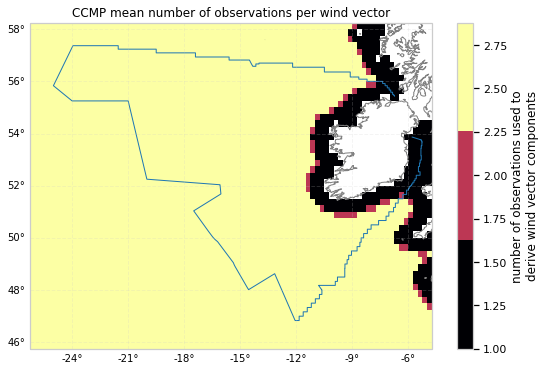

In [8]:
MAP_PROJECTION = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(projection=MAP_PROJECTION))

mean_nobs.plot(cmap=plt.cm.get_cmap('inferno', 3), vmin=mean_nobs.min(), vmax=mean_nobs.max(), ax=ax)
ax.set_aspect('auto')

# ICS boundary
ax.add_geometries([icsline], MAP_PROJECTION, edgecolor = sns.color_palette()[0], facecolor='none')

# Lat/lon gridlines
gl = ax.gridlines(draw_labels=['left', 'bottom'], alpha=0.2, linestyle='--', formatter_kwargs=dict(direction_label=False))
label_style = {'size': 10}
gl.xlabel_style = label_style
gl.ylabel_style = label_style
    
ax.coastlines(color='grey')
ax.set_title('CCMP mean number of observations per wind vector');

----------------------------------------------------------------
### CCMP wind speed (2015 - 2021)

Wind speed is loaded into an [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html):

In [9]:
ds.wind_speed

<xarray.DataArray 'wind_speed' (height: 1, time: 9744, latitude: 50,
                                longitude: 86)>
dask.array<where, shape=(1, 9744, 50, 86), dtype=float32, chunksize=(1, 8000, 50, 86), chunktype=numpy.ndarray>
Coordinates:
  * height     (height) int64 10
  * latitude   (latitude) float32 45.88 46.12 46.38 46.62 ... 57.62 57.88 58.12
  * longitude  (longitude) float32 333.9 334.1 334.4 334.6 ... 354.6 354.9 355.1
  * time       (time) datetime64[ns] 2015-01-16 ... 2021-09-30T18:00:00
Attributes:
    long_name:  Wind speed
    units:      m s**-1

#### Calculate mean wind speed over time dimension at AOI grid coordinates

To perform some analysis at known AOI latitude/longitude coordinates, the [`xarray.DataArray.sel(..., method='nearest')`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html) function may be used to select a subset of the data array (or data set) at coordinates nearest to the specified parameters. Here, mean wind speed over the `time` dimension is determined for the specified coordinates.

In [10]:
ds.wind_speed.sel(longitude=-5.4302, latitude=53.4836, method='nearest').mean(dim='time').compute()

<xarray.DataArray 'wind_speed' (height: 1)>
array([10.082178], dtype=float32)
Coordinates:
  * height     (height) int64 10
    latitude   float32 53.38
    longitude  float32 333.9